In [63]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tabulate import tabulate

In [2]:
columns = ['acc_chest_X', 'acc_chest_Y', 'acc_chest_Z',
           'ecg_1', 'ecg_2',
           'acc_la_X', 'acc_la_Y', 'acc_la_Z',
           'gyr_la_X', 'gyr_la_Y', 'gyr_la_Z',
           'mag_la_X', 'mag_la_Y', 'mag_la_Z',
           'acc_RLA_X', 'acc_RLA_Y', 'acc_RLA_Z',
           'gyr_RLA_X', 'gyr_RLA_Y', 'gyr_RLA_Z',
           'mag_RLA_X', 'mag_RLA_Y', 'mag_RLA_Z',
           'label']

In [3]:
df = pd.DataFrame()
for i in range(1,11):
    temp = pd.read_csv(f'../data/raw/MHEALTHDATASET/mHealth_subject{i}.log', sep='\t', header=None)
    temp.columns= columns
    temp['subject_id'] = i
    df = df.append(temp, ignore_index=True)

In [4]:
df = df.reset_index(drop=True)

In [5]:
df = df[df['label'] != 0]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343195 entries, 6656 to 1213645
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   acc_chest_X  343195 non-null  float64
 1   acc_chest_Y  343195 non-null  float64
 2   acc_chest_Z  343195 non-null  float64
 3   ecg_1        343195 non-null  float64
 4   ecg_2        343195 non-null  float64
 5   acc_la_X     343195 non-null  float64
 6   acc_la_Y     343195 non-null  float64
 7   acc_la_Z     343195 non-null  float64
 8   gyr_la_X     343195 non-null  float64
 9   gyr_la_Y     343195 non-null  float64
 10  gyr_la_Z     343195 non-null  float64
 11  mag_la_X     343195 non-null  float64
 12  mag_la_Y     343195 non-null  float64
 13  mag_la_Z     343195 non-null  float64
 14  acc_RLA_X    343195 non-null  float64
 15  acc_RLA_Y    343195 non-null  float64
 16  acc_RLA_Z    343195 non-null  float64
 17  gyr_RLA_X    343195 non-null  float64
 18  gyr_RLA_Y    343195 

In [7]:
columns.append('subject_id')

In [8]:
FEATURES = ['acc_chest_X', 'acc_chest_Y', 'acc_chest_Z',
           'acc_la_X', 'acc_la_Y', 'acc_la_Z',
           'gyr_la_X', 'gyr_la_Y', 'gyr_la_Z',
           'mag_la_X', 'mag_la_Y', 'mag_la_Z',
           'acc_RLA_X', 'acc_RLA_Y', 'acc_RLA_Z',
           'gyr_RLA_X', 'gyr_RLA_Y', 'gyr_RLA_Z',
           'mag_RLA_X', 'mag_RLA_Y', 'mag_RLA_Z']

In [9]:
df = df.fillna(0)

# All sensor channels are normalized
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

### Subject wise train test split

In [1]:
activity_map = {0:'null', 1:'Standing still', 2: 'Sitting and relaxing', 3:'Lying down',
4:'Walking',5:'Climbing stairs',6:'Waist bends forward',7: 'Frontal elevation of arms',
8: 'Knees bending (crouching)',9:'Cycling', 10: 'Jogging',11: 'Running',12:'Jump front & back'}

In [2]:
import json

with open("activities/mhealth_activity.json", "w") as outfile:  
    json.dump(activity_map, outfile, indent = 4) 

In [11]:
def get_activity_dict(activity_map:dict, novel_classes:list):
    _activity_map = activity_map.copy()
    novel_map = dict()
    
    for activity_class in novel_classes:
        novel_map[activity_class] = activity_map[activity_class]
        _activity_map.pop(activity_class)
        
    return _activity_map, novel_map

In [12]:
NOVEL_CLASSES = [1, 4, 8]

In [13]:
_activity_map, novel_map = get_activity_dict(activity_map, NOVEL_CLASSES)

print(_activity_map)
print(novel_map)

{0: 'null', 2: 'Sitting and relaxing', 3: 'Lying down', 5: 'Climbing stairs', 6: 'Waist bends forward', 7: 'Frontal elevation of arms', 9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'}
{1: 'Standing still', 4: 'Walking', 8: 'Knees bending (crouching)'}


In [14]:
holdout_data = df.loc[df['label'].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

In [15]:
train_df = df[df['subject_id'] != 1]
test_df = df[df['subject_id'] == 1]

In [16]:
# ## noise

# df_aug = train_df.copy(deep=True)
# mu = 0.0
# sigma = 0.5
# for i in range(4):
#     noise = np.random.normal(mu, sigma, [train_df.shape[0], 9])
#     df_noise = train_df[FEATURES].copy(deep=True)
#     df_noise = df_noise + noise

#     df_noise['timestep'] = train_df['timestep']
#     df_noise['subject_id'] = train_df['subject_id']
#     df_noise['file_id'] = train_df['file_id'] + '_aug_'+ str(i)

#     df_noise = df_noise[train_df.columns]
#     df_aug = pd.concat([df_aug, df_noise], ignore_index=True)
# train_df = df_aug.reset_index(drop=True)

### Window - session

In [17]:
WINDOW_SIZE =50*15
STRIDE = 50*3

In [18]:
def create_windowed_dataset(df, features=FEATURES, class_label = 'label', window_size=24, stride = 12):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []
    seg_start= 0
    seg_end = window_size
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels)

In [19]:
X_train, y_train = create_windowed_dataset(train_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
X_test, y_test = create_windowed_dataset(test_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
X_holdout, y_holdout = create_windowed_dataset(novel_data, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

In [20]:
N_WINDOW = 15
N_TIMESTEP = 50

In [22]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train - 1) #, num_classes=len(_activity_map.keys()))
y_test = tf.keras.utils.to_categorical(y_test - 1) #, num_classes=len(_activity_map.keys()))
y_holdout = tf.keras.utils.to_categorical(y_holdout-1) #, num_classes=len(activity_map.keys()))

In [23]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_holdout.shape)
print(y_holdout.shape)

(1160, 15, 50, 21)
(1160, 12)
(131, 15, 50, 21)
(131, 12)
(471, 15, 50, 21)
(471, 8)


## Attention Model

In [24]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

### Self Attention

In [25]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [26]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [28]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [29]:
class CombinedSensorSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate, concat=True):
        super(CombinedSensorSelfAttention, self).__init__()
        self.concat = concat
        self.agr_attn = AggregateAttention(d_model, num_heads)
        self.ffn1 = point_wise_feed_forward_network(d_model, dff)
        self.ffn2 = point_wise_feed_forward_network(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        if self.concat:
            x = tf.concat(x, axis=1)
        x = self.ffn1(x)
        x, attn_score = self.agr_attn(x, x)
        x = self.dropout1(x)
        ffn_output = self.ffn2(x)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm(ffn_output + x)  # (batch_size, d_model)
        return out, attn_score

In [30]:
class DataTransform(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(DataTransform, self).__init__()
        # self.ln = tf.keras.layers.LayerNormalization()
        self.conv_1d = tf.keras.layers.Conv1D(d_model, 1, activation='relu')
    
    def call(self, x):
        # x = self.ln(x)
        x = self.conv_1d(x)
        return x

In [31]:
class ModalityEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=2, dropout_rate=0.1):
        super(ModalityEncoderBlock, self).__init__()
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.look_ahead_mask = create_look_ahead_mask(n_timesteps)
        self.data_transform = DataTransform(d_model)
        self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.num_sa_blocks = num_sa_blocks
        self.self_attn_blocks = [ SelfAttentionBlock(d_model, num_heads, dff, dropout_rate)
                                        for _ in range(self.num_sa_blocks)]
        # self.agr_attn = AttentionWithContext(return_attention=True)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.data_transform(x)
        x = self.pe(x)
        for i in range(self.num_sa_blocks):
            # x = self.self_attn_blocks[i](x, mask=self.look_ahead_mask)
            x = self.self_attn_blocks[i](x)
        return x


    def compute_output_shape(x, input_shape):
        return tf.TensorShape([input_shape[0], self.d_model])

In [32]:
def get_modality_encoder(modality_indices, n_timesteps, n_features,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
    model = tf.keras.Model(inputs=inputs, outputs=modality_outputs)
    return model

In [33]:
class MultiWindowEncoder(tf.keras.layers.Layer):
    def __init__(self, modality_indices, n_window, n_timesteps, n_features, d_model, num_heads, dff, dropout_rate=0.1):
        super(MultiWindowEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.window_encoder = get_modality_encoder(modality_indices,n_timesteps=n_timesteps, n_features=n_features, d_model=d_model, num_heads = num_heads, dff=dff, dropout_rate=dropout_rate)
        self.combined_sensor_attn = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_dim = tf.shape(x)[-1]
        x = tf.reshape(x, (-1, self.n_timesteps, feature_dim)) # all sessions in batch dim
        x = self.window_encoder(x)
        x, attn_scores = self.combined_sensor_attn(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model))
        attn_scores = tf.reshape(attn_scores, (batch_size, -1, self.n_timesteps))
        return x, attn_scores

In [34]:
def get_modality_model_w_time_hierarchy(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=False) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

In [35]:
tf.keras.backend.clear_session()
# [0,3,5,14,23]
n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
model = get_modality_model_w_time_hierarchy([0,3,12,21], n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics='accuracy')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 50, 21)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 384000    
_________________________________________________________________
modality_encoder_block_3 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
_________________________________________________________________
dense_64 (Dense)             (None, 12)                780       
Total params: 571,724
Trainable params: 571,724
Non-trainable params: 0
_________________________________________________________________


In [36]:
verbose, epochs, batch_size = 1, 35, 128
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,verbose=1, mode='max')
# mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/35
10/10 [==============================] - 3s 257ms/step - loss: 2.3592 - accuracy: 0.1914 - val_loss: 1.7699 - val_accuracy: 0.3130
Epoch 2/35
10/10 [==============================] - 1s 119ms/step - loss: 1.8444 - accuracy: 0.3129 - val_loss: 1.3870 - val_accuracy: 0.4885
Epoch 3/35
10/10 [==============================] - 1s 119ms/step - loss: 1.4247 - accuracy: 0.4810 - val_loss: 1.1445 - val_accuracy: 0.5649
Epoch 4/35
10/10 [==============================] - 1s 119ms/step - loss: 1.0868 - accuracy: 0.6379 - val_loss: 0.9091 - val_accuracy: 0.5878
Epoch 5/35
10/10 [==============================] - 1s 119ms/step - loss: 0.7815 - accuracy: 0.7836 - val_loss: 0.6879 - val_accuracy: 0.8244
Epoch 6/35
10/10 [==============================] - 1s 119ms/step - loss: 0.6171 - accuracy: 0.8336 - val_loss: 0.6029 - val_accuracy: 0.7328
Epoch 7/35
10/10 [==============================] - 1s 118ms/step - loss: 0.4551 - accuracy: 0.8905 - val_loss: 0.4382 - val_accuracy: 0.8550
Epoch 

In [37]:
pred = model.predict(X_test, batch_size=128)

In [38]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        16
           8       1.00      1.00      1.00        16
           9       1.00      0.94      0.97        16
          10       0.80      1.00      0.89        16
          11       0.00      0.00      0.00         3

    accuracy                           0.97       131
   macro avg       0.87      0.88      0.87       131
weighted avg       0.95      0.97      0.96       131



/home/agency/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

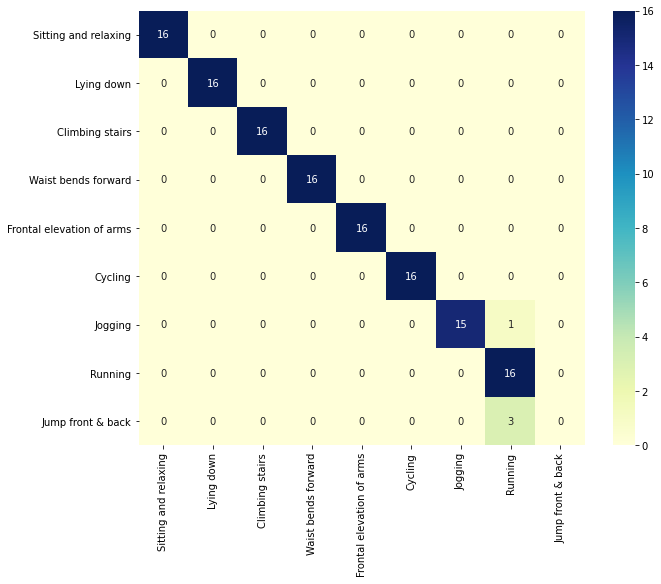

In [40]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
activity_list = list(_activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list[1:], columns=activity_list[1:])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

# VAE [Novelty Detection]

In [41]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_3
combined_sensor_self_attention_1
dense_64


In [42]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [43]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 50, 21)]      0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 384000    
_________________________________________________________________
modality_encoder_block_3 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
Total params: 570,944
Trainable params: 0
Non-trainable params: 570,944
_________________________________________________________________


In [44]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data, _ = self.base_model(data)
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, reconstructed))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [45]:
hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

In [47]:
vae_history = hsa_vae.fit(X_train, epochs=50, batch_size=64)

Epoch 1/50
19/19 [==============================] - 1s 39ms/step - loss: 1.5571 - reconstruction_loss: 1.2725 - kl_loss: 0.2846
Epoch 2/50
19/19 [==============================] - 1s 39ms/step - loss: 1.3100 - reconstruction_loss: 1.2237 - kl_loss: 0.0863
Epoch 3/50
19/19 [==============================] - 1s 40ms/step - loss: 1.2252 - reconstruction_loss: 1.1823 - kl_loss: 0.0429
Epoch 4/50
19/19 [==============================] - 1s 39ms/step - loss: 1.1794 - reconstruction_loss: 1.1489 - kl_loss: 0.0305
Epoch 5/50
19/19 [==============================] - 1s 41ms/step - loss: 1.1392 - reconstruction_loss: 1.1154 - kl_loss: 0.0238
Epoch 6/50
19/19 [==============================] - 1s 42ms/step - loss: 1.1101 - reconstruction_loss: 1.0887 - kl_loss: 0.0214
Epoch 7/50
19/19 [==============================] - 1s 43ms/step - loss: 1.0854 - reconstruction_loss: 1.0656 - kl_loss: 0.0197
Epoch 8/50
19/19 [==============================] - 1s 40ms/step - loss: 1.0704 - reconstruction_loss: 1

## Novelty Result

In [48]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [49]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [50]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [51]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [52]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [53]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [54]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.35)

              precision    recall  f1-score   support

       KNOWN       0.25      0.29      0.27       131
       NOVEL       0.79      0.76      0.77       471

    accuracy                           0.65       602
   macro avg       0.52      0.52      0.52       602
weighted avg       0.67      0.65      0.66       602



In [55]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [60]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [66]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.0, 1.01, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

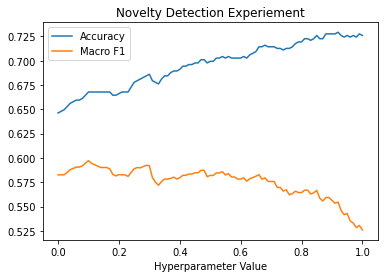

Index with Top Accuracy and Macro F1 :  [92 88 89 90 91] [10  9 11 12 29]
Most Important Index :  []
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0    |   0.646179 |   0.582569 |
+---------+-------------------------+------------+------------+
|       1 |                    0.01 |   0.647841 |   0.582601 |
+---------+-------------------------+------------+------------+
|       2 |                    0.02 |   0.649502 |   0.582608 |
+---------+-------------------------+------------+------------+
|       3 |                    0.03 |   0.652824 |   0.585245 |
+---------+-------------------------+------------+------------+
|       4 |                    0.04 |   0.656146 |   0.587888 |
+---------+-------------------------+------------+------------+
|       5 |                    0.05 |   0.657807 |   0.589212 |
+--

In [67]:
# Result
hparam_search() 

## LOSO

In [ ]:
def run_experiment():
    FEATURES = ['acc_chest_X', 'acc_chest_Y', 'acc_chest_Z',
           'acc_la_X', 'acc_la_Y', 'acc_la_Z',
           'gyr_la_X', 'gyr_la_Y', 'gyr_la_Z',
           'mag_la_X', 'mag_la_Y', 'mag_la_Z',
           'acc_RLA_X', 'acc_RLA_Y', 'acc_RLA_Z',
           'gyr_RLA_X', 'gyr_RLA_Y', 'gyr_RLA_Z',
           'mag_RLA_X', 'mag_RLA_Y', 'mag_RLA_Z']
    N_WINDOW = 15
    N_TIMESTEP = 50

    SLIDING_WINDOW_LENGTH =50*15
    SLIDING_WINDOW_STEP = 50*3

    for i in range(1,11):
        print('Test subject: ', str(i))
        train_df = df[df['subject_id'] != i]
        test_df = df[df['subject_id'] == i]

        X_train, y_train = create_windowed_dataset(train_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
        # X_val, y_val = create_windowed_dataset(val_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
        X_test, y_test = create_windowed_dataset(test_df, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
        # X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

        y_train = tf.keras.utils.to_categorical(y_train)
        # y_val = tf.keras.utils.to_categorical(y_val)
        y_test = tf.keras.utils.to_categorical(y_test)

        tf.keras.backend.clear_session()
        # [0,3,5,14,23]
        n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
        model = get_modality_model_w_time_hierarchy([0,3,12,21], n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')
        
        verbose, epochs, batch_size = 0, 50, 64
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        activity_list = list(activity_map.values())[1:]
        pred = model.predict(X_test, batch_size=batch_size)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), target_names=activity_list))
        confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
        df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
        plt.figure(figsize = (10,8))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
        plt.show()

Test subject:  1
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      0.81      0.90        16
          Climbing stairs       0.84      1.00      0.91        16
      Waist bends forward       1.00      1.00      1.00        16
Frontal elevation of arms       1.00      1.00      1.00        16
Knees bending (crouching)       1.00      1.00      1.00        18
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       1.00      1.00      1.00         3

                 accuracy                           0.98       181
                macro avg       0.99      0

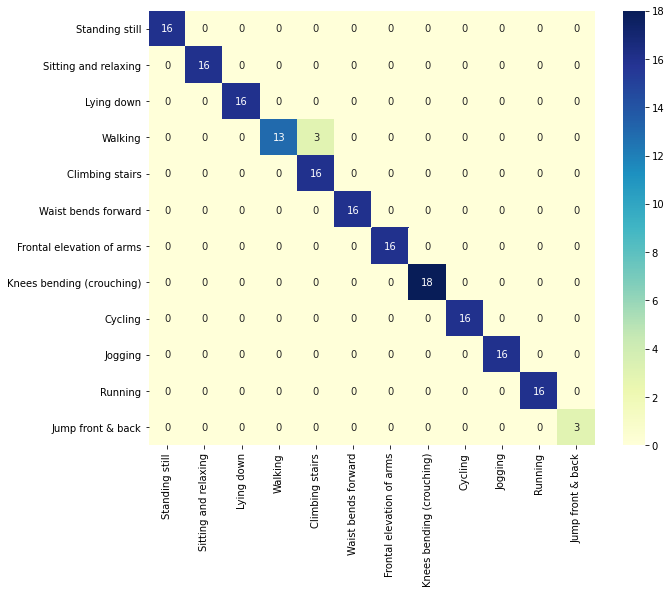

Test subject:  2
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      0.47      0.64        17
Frontal elevation of arms       1.00      1.00      1.00        18
Knees bending (crouching)       0.67      1.00      0.80        18
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      0.31      0.48        16
                  Running       0.59      1.00      0.74        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           0.89       183
                macro avg       0.94      0

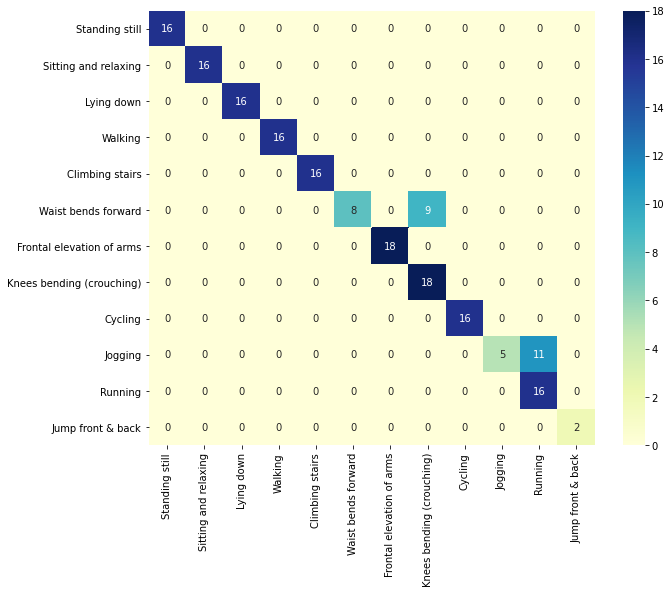

Test subject:  3


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       0.00      0.00      0.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       0.73      1.00      0.84        16
          Climbing stairs       0.91      0.62      0.74        16
      Waist bends forward       1.00      1.00      1.00        17
Frontal elevation of arms       1.00      1.00      1.00        18
Knees bending (crouching)       0.53      1.00      0.69        17
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      0.12      0.22        16
                  Running       0.53      1.00      0.70        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           0.80       182
                macro avg       0.81      0.81      0.77    

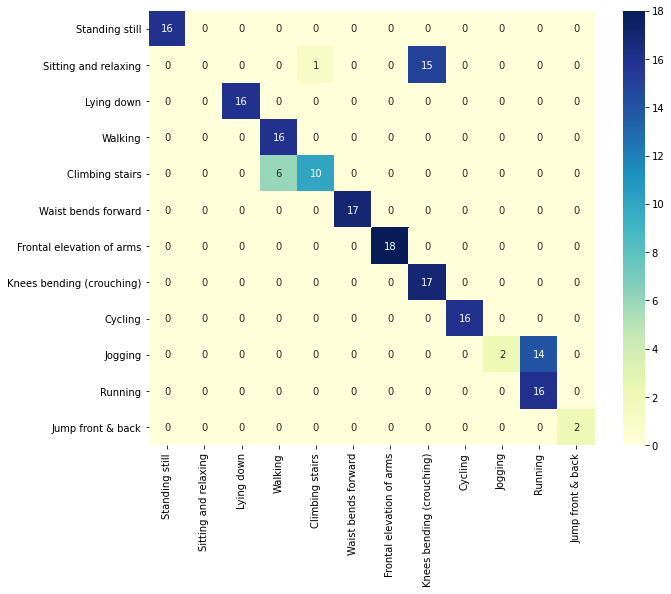

Test subject:  4
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       0.00      0.00      0.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        18
Frontal elevation of arms       0.52      1.00      0.68        17
Knees bending (crouching)       1.00      1.00      1.00        16
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           0.91       181
                macro avg       0.88      0

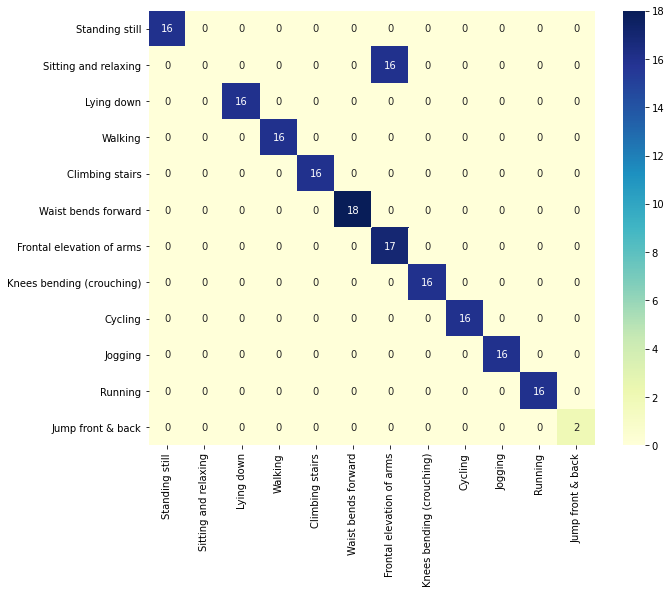

Test subject:  5
                           precision    recall  f1-score   support

           Standing still       0.48      1.00      0.65        16
     Sitting and relaxing       0.00      0.00      0.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      0.93      0.96        14
Frontal elevation of arms       1.00      1.00      1.00        15
Knees bending (crouching)       1.00      1.00      1.00        14
                  Cycling       1.00      1.00      1.00        16
                  Jogging       0.89      1.00      0.94        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       0.00      0.00      0.00         2

                 accuracy                           0.89       173
                macro avg       0.78      0

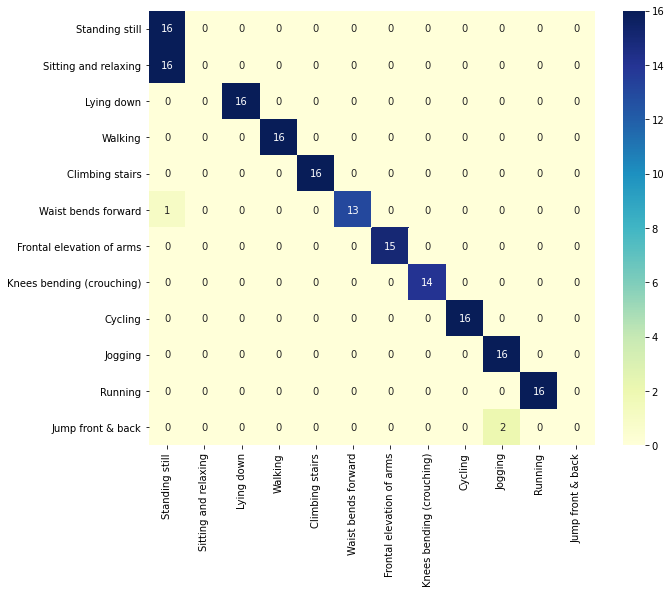

Test subject:  6
                           precision    recall  f1-score   support

           Standing still       0.89      1.00      0.94        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      0.80      0.89        10
Frontal elevation of arms       1.00      1.00      1.00         9
Knees bending (crouching)       1.00      1.00      1.00        11
                  Cycling       1.00      1.00      1.00        16
                  Jogging       0.00      0.00      0.00        16
                  Running       0.48      1.00      0.65        16
        Jump front & back       0.00      0.00      0.00         2

                 accuracy                           0.88       160
                macro avg       0.78      0

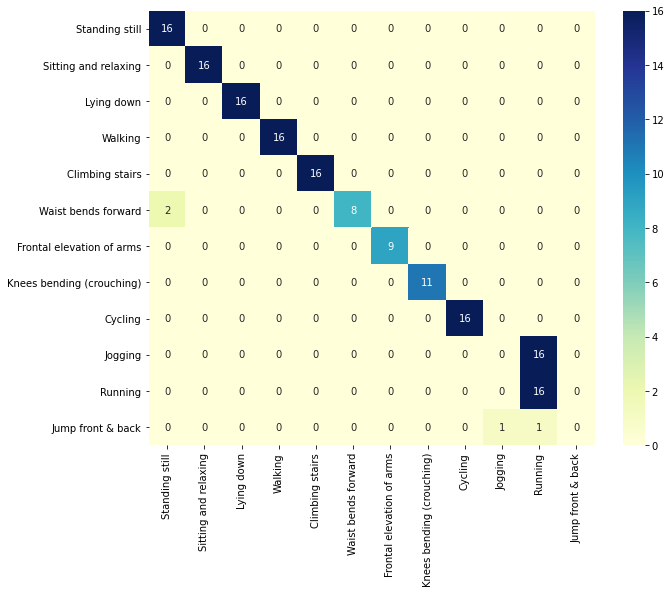

Test subject:  7
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       0.67      1.00      0.80        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        16
Frontal elevation of arms       1.00      0.43      0.60        14
Knees bending (crouching)       1.00      1.00      1.00        14
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           0.95       174
                macro avg       0.97      0

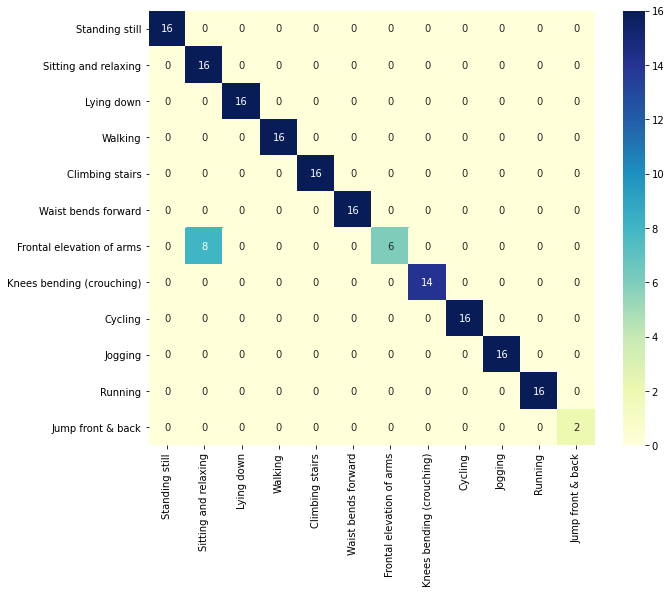

Test subject:  8
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       0.50      1.00      0.67        16
          Climbing stairs       0.00      0.00      0.00        16
      Waist bends forward       1.00      1.00      1.00        10
Frontal elevation of arms       1.00      1.00      1.00        16
Knees bending (crouching)       1.00      0.92      0.96        13
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       0.89      1.00      0.94        16
        Jump front & back       0.00      0.00      0.00         2

                 accuracy                           0.89       169
                macro avg       0.78      0

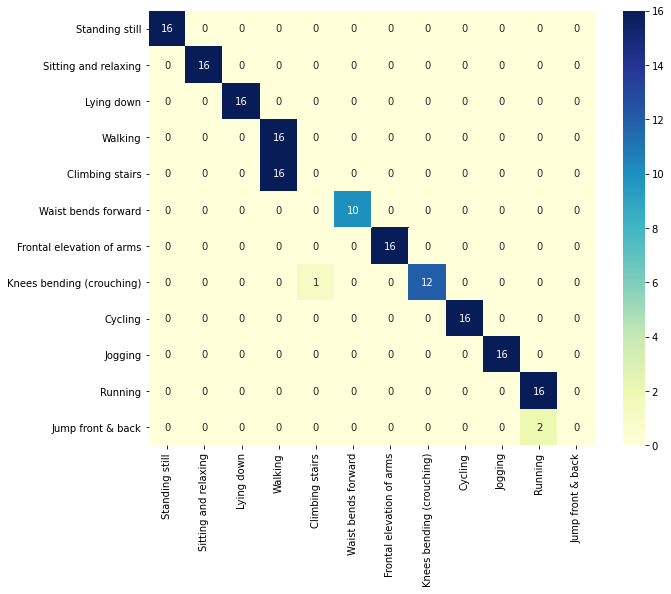

Test subject:  9
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        15
Frontal elevation of arms       1.00      1.00      1.00        15
Knees bending (crouching)       1.00      1.00      1.00        15
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       1.00      1.00      1.00         3

                 accuracy                           1.00       176
                macro avg       1.00      1

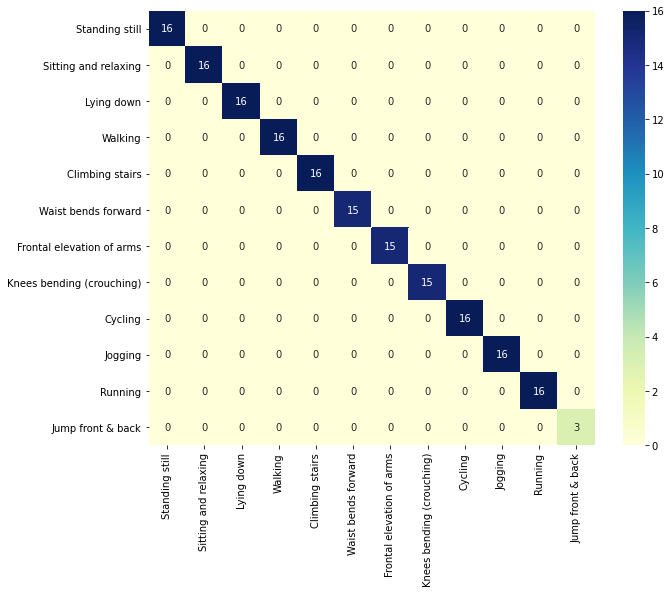

Test subject:  10
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       0.94      1.00      0.97        16
               Lying down       0.94      1.00      0.97        16
                  Walking       1.00      0.88      0.93        16
          Climbing stairs       1.00      0.69      0.81        16
      Waist bends forward       1.00      0.92      0.96        12
Frontal elevation of arms       1.00      1.00      1.00        14
Knees bending (crouching)       0.22      0.13      0.17        15
                  Cycling       0.55      1.00      0.71        16
                  Jogging       1.00      1.00      1.00        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       1.00      0.50      0.67         2

                 accuracy                           0.87       171
                macro avg       0.89      

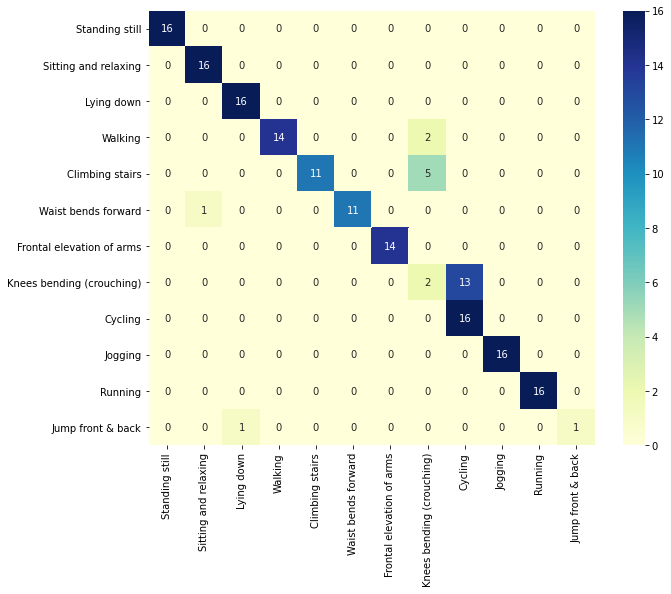

In [ ]:
run_experiment()

Test subject:  1
                           precision    recall  f1-score   support

           Standing still       0.50      1.00      0.67        16
     Sitting and relaxing       0.00      0.00      0.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        16
Frontal elevation of arms       1.00      1.00      1.00        16
Knees bending (crouching)       1.00      1.00      1.00        18
                  Cycling       1.00      1.00      1.00        16
                  Jogging       0.00      0.00      0.00        16
                  Running       0.50      1.00      0.67        16
        Jump front & back       1.00      1.00      1.00         3

                 accuracy                           0.82       181
                macro avg       0.75      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


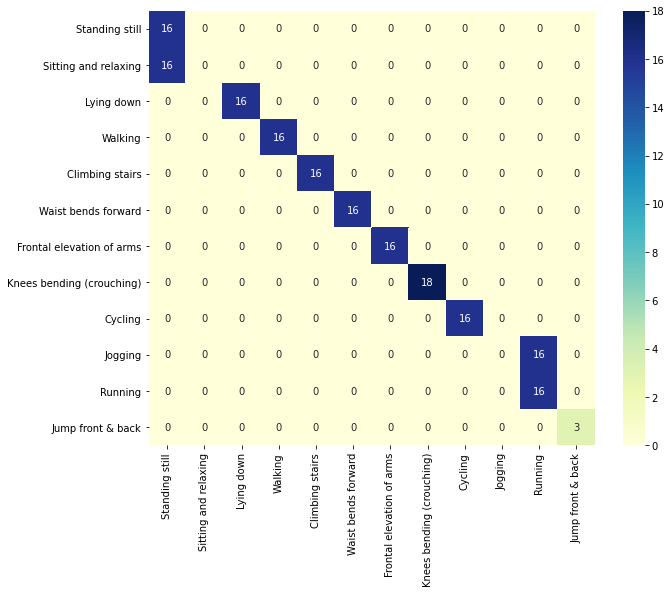

Test subject:  2
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        17
Frontal elevation of arms       1.00      1.00      1.00        18
Knees bending (crouching)       1.00      1.00      1.00        18
                  Cycling       1.00      1.00      1.00        16
                  Jogging       0.00      0.00      0.00        16
                  Running       0.50      1.00      0.67        16
        Jump front & back       0.00      0.00      0.00         2

                 accuracy                           0.90       183
                macro avg       0.79      0

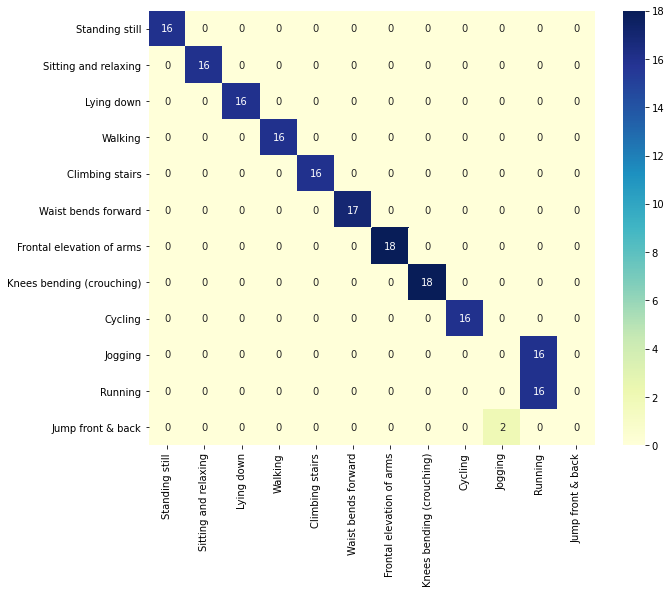

Test subject:  3
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       0.00      0.00      0.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       0.52      1.00      0.68        17
Frontal elevation of arms       1.00      1.00      1.00        18
Knees bending (crouching)       1.00      1.00      1.00        17
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      0.25      0.40        16
                  Running       0.57      1.00      0.73        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           0.85       182
                macro avg       0.84      0

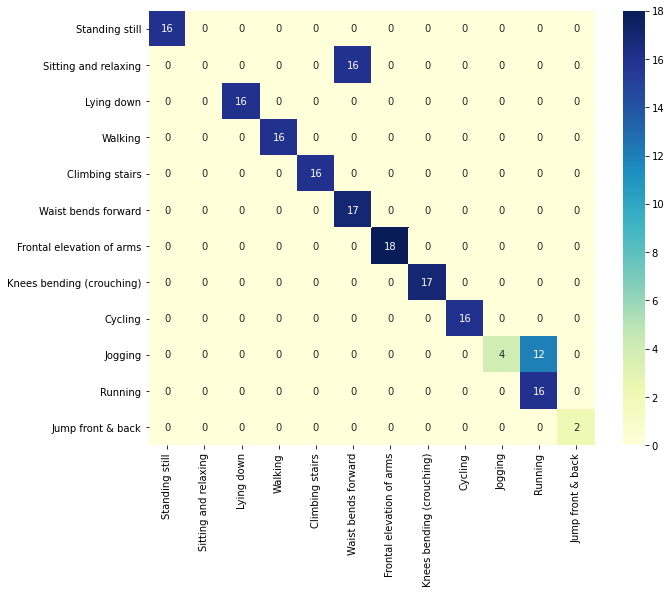

Test subject:  4
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       0.00      0.00      0.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       0.89      1.00      0.94        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        18
Frontal elevation of arms       1.00      1.00      1.00        17
Knees bending (crouching)       1.00      1.00      1.00        16
                  Cycling       0.50      1.00      0.67        16
                  Jogging       0.50      1.00      0.67        16
                  Running       0.00      0.00      0.00        16
        Jump front & back       0.00      0.00      0.00         2

                 accuracy                           0.81       181
                macro avg       0.66      0

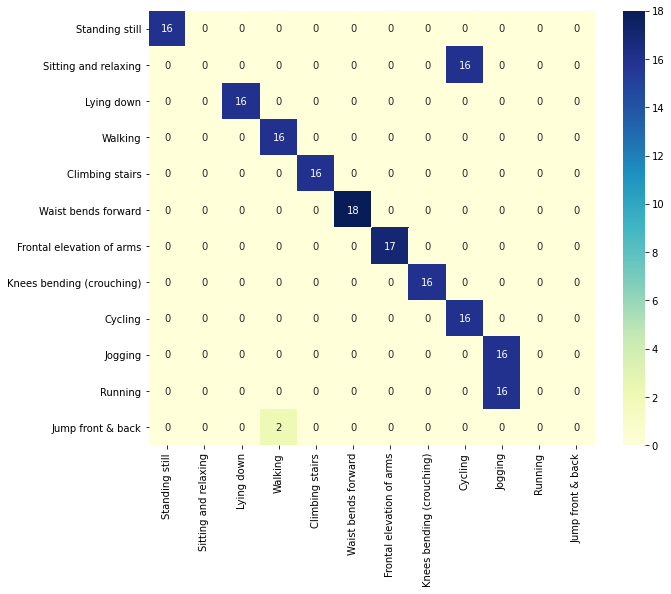

Test subject:  5
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        14
Frontal elevation of arms       1.00      1.00      1.00        15
Knees bending (crouching)       1.00      1.00      1.00        14
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       0.89      1.00      0.94        16
        Jump front & back       0.00      0.00      0.00         2

                 accuracy                           0.99       173
                macro avg       0.91      0

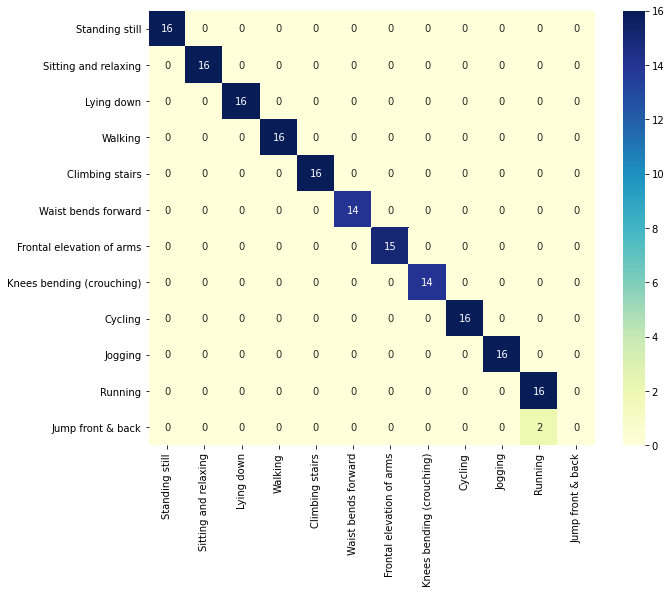

Test subject:  6
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       0.94      1.00      0.97        16
          Climbing stairs       1.00      0.94      0.97        16
      Waist bends forward       1.00      1.00      1.00        10
Frontal elevation of arms       1.00      1.00      1.00         9
Knees bending (crouching)       0.41      1.00      0.58        11
                  Cycling       0.00      0.00      0.00        16
                  Jogging       0.50      1.00      0.67        16
                  Running       0.00      0.00      0.00        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           0.79       160
                macro avg       0.74      0

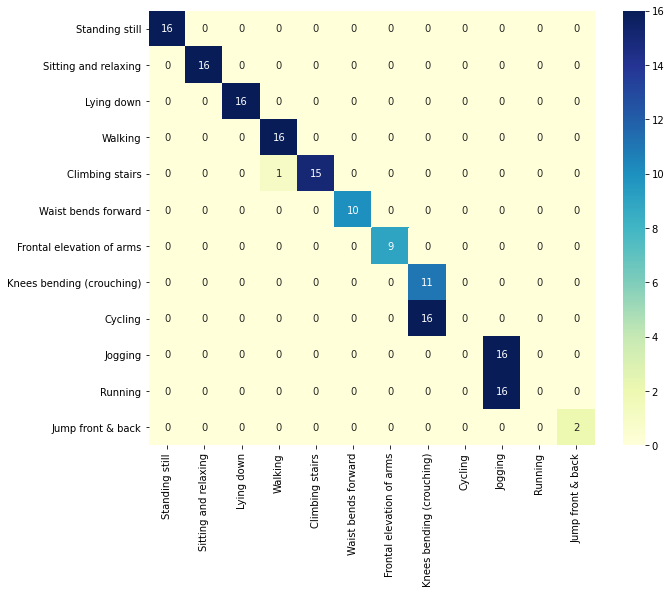

Test subject:  7
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        16
Frontal elevation of arms       1.00      1.00      1.00        14
Knees bending (crouching)       1.00      1.00      1.00        14
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           1.00       174
                macro avg       1.00      1

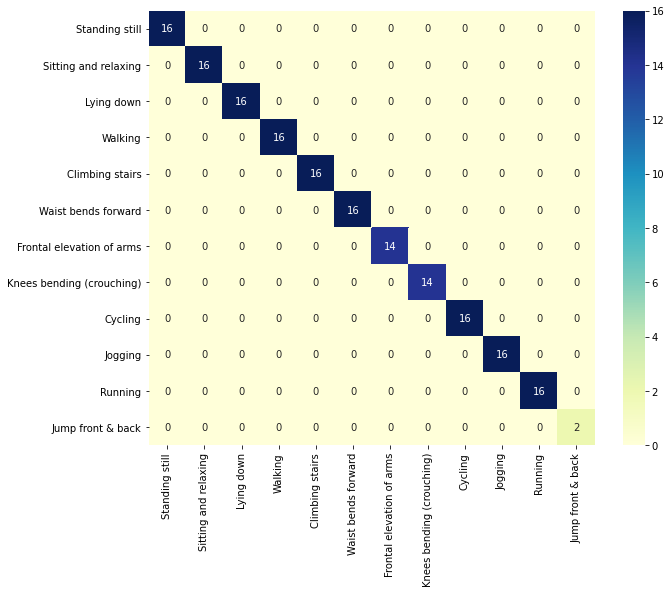

Test subject:  8
                           precision    recall  f1-score   support

           Standing still       0.88      0.88      0.88        16
     Sitting and relaxing       0.94      1.00      0.97        16
               Lying down       1.00      1.00      1.00        16
                  Walking       0.64      1.00      0.78        16
          Climbing stairs       0.41      0.44      0.42        16
      Waist bends forward       1.00      0.80      0.89        10
Frontal elevation of arms       1.00      1.00      1.00        16
Knees bending (crouching)       0.15      0.23      0.18        13
                  Cycling       0.00      0.00      0.00        16
                  Jogging       0.84      1.00      0.91        16
                  Running       1.00      0.81      0.90        16
        Jump front & back       1.00      1.00      1.00         2

                 accuracy                           0.75       169
                macro avg       0.74      0

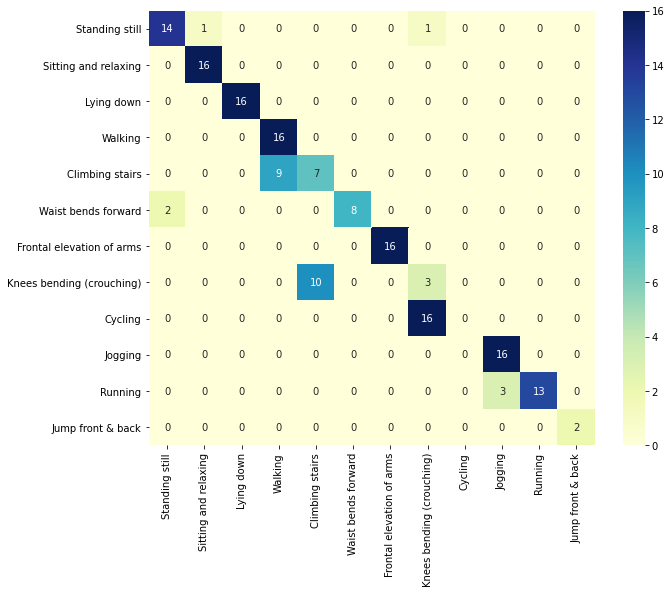

Test subject:  9
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       1.00      1.00      1.00        16
          Climbing stairs       1.00      1.00      1.00        16
      Waist bends forward       1.00      1.00      1.00        15
Frontal elevation of arms       1.00      1.00      1.00        15
Knees bending (crouching)       1.00      1.00      1.00        15
                  Cycling       1.00      1.00      1.00        16
                  Jogging       1.00      1.00      1.00        16
                  Running       1.00      1.00      1.00        16
        Jump front & back       1.00      1.00      1.00         3

                 accuracy                           1.00       176
                macro avg       1.00      1

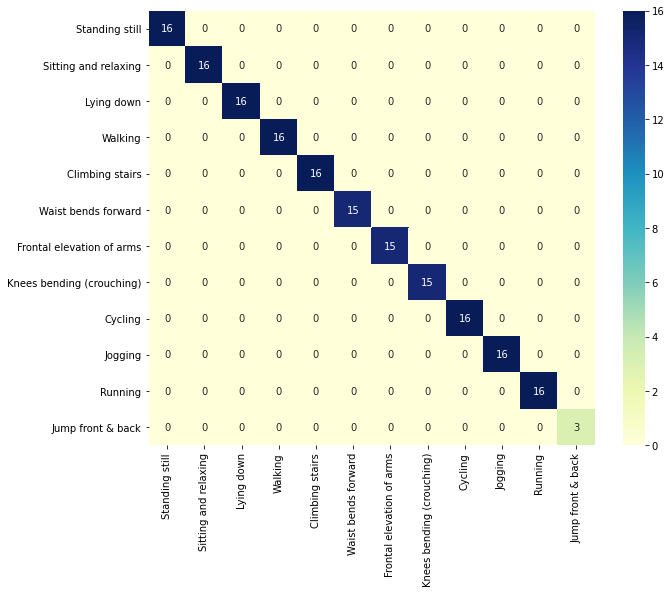

Test subject:  10
                           precision    recall  f1-score   support

           Standing still       1.00      1.00      1.00        16
     Sitting and relaxing       1.00      1.00      1.00        16
               Lying down       1.00      1.00      1.00        16
                  Walking       0.89      1.00      0.94        16
          Climbing stairs       1.00      0.88      0.93        16
      Waist bends forward       0.44      1.00      0.62        12
Frontal elevation of arms       1.00      1.00      1.00        14
Knees bending (crouching)       0.00      0.00      0.00        15
                  Cycling       1.00      1.00      1.00        16
                  Jogging       0.76      1.00      0.86        16
                  Running       1.00      0.81      0.90        16
        Jump front & back       0.00      0.00      0.00         2

                 accuracy                           0.87       171
                macro avg       0.76      

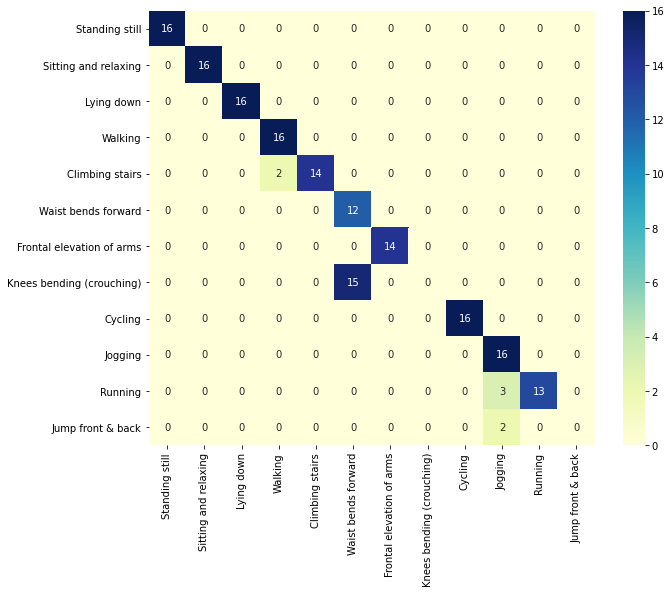

In [ ]:
run_experiment()

In [ ]:
run_experiment()